# **Use Case - Environmental Imapct Analysis**


# Importing Required Libraries

This section loads all of the Python libraries required for the environmental impact study.
Pandas and NumPy handle core data manipulation, whereas scikit-learn provides the preprocessing tools, regression models, and evaluation metrics needed for machine learning development. Matplotlib facilitates the visualization of model outputs and insights.
Additional configuration variables, such as silencing warnings and increasing column visibility, help to maintain a clean and understandable workflow throughout analysis and model reproduction.

In [17]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)


# Loading the EV and ICE consumption datasets
In this phase, the notebook provides the directory path where the car datasets are stored before loading each file into a separate Pandas DataFrame. These files include energy or fuel consumption values for electric cars (EVs), diesel vehicles, and gasoline vehicles with varying octane ratings. Loading them individually enables unambiguous preprocessing and subsequent integration into a uniform modeling framework. Displaying the first few rows of the EV and diesel datasets serves as a first check to ensure that the files were properly imported and formatted.

In [18]:
# Paths to data files
base_path = "/content/Data/"

ev_path       = base_path + "Pure electric consumption.csv"
diesel_path   = base_path + "Diesel consumption.csv"
petrol91_path = base_path + "petrol91RON consumption.csv"
petrol95_path = base_path + "petrol95RON consumption.csv"
petrol98_path = base_path + "petrol98RON consumption.csv"

# Load datasets
ev         = pd.read_csv(ev_path)
diesel     = pd.read_csv(diesel_path)
petrol91   = pd.read_csv(petrol91_path)
petrol95   = pd.read_csv(petrol95_path)
petrol98   = pd.read_csv(petrol98_path)

ev.head(), diesel.head()


(   ModelReleaseYear    Make ModelReleaseVersion     Model        Variant  \
 0              2023     BYD                EM2E   DOLPHIN        Dynamic   
 1              2023   Lexus                 NaN   UX 300e            NaN   
 2              2024  Toyota                 NaN      bZ4X            NaN   
 3              2023      MG                 NaN       MG4  64kWh EV RWD    
 4              2024   Chery                 NaN  Omoda E5            NaN   
 
    EngineDisplacement EngineConfiguration EngineInduction  FwdGearsNo  \
 0                 0.0            Electric             NaN           1   
 1                 0.0            Electric             NaN           1   
 2                 0.0            Electric             NaN           1   
 3                 0.0            Electric             NaN           1   
 4                 0.0            Electric             NaN           1   
 
   TransmissionTypeDescription  SideDoorNo  SeatingCapacity BodyStyle  \
 0               

# Inspecting Dataset Dimensions and Structure

This phase gives a first assessment of the imported datasets by printing their shapes and giving the column names of the EV dataset. Examining dataset dimensions confirms that each file was accurately loaded and identifies any significant differences in size between vehicle types. Viewing the EV dataset's columns confirms the presence of essential variables and facilitates early planning for preprocessing and feature engineering. This structural assessment provides confidence in the data's integrity and readiness before deeper analysis begins.

In [19]:
print("EV shape:", ev.shape)
print("Diesel shape:", diesel.shape)
print("Petrol 91 shape:", petrol91.shape)
print("Petrol 95 shape:", petrol95.shape)
print("Petrol 98 shape:", petrol98.shape)

print("\nEV columns:\n", ev.columns)


EV shape: (200, 31)
Diesel shape: (200, 31)
Petrol 91 shape: (200, 31)
Petrol 95 shape: (200, 31)
Petrol 98 shape: (200, 31)

EV columns:
 Index(['ModelReleaseYear', 'Make', 'ModelReleaseVersion', 'Model', 'Variant',
       'EngineDisplacement', 'EngineConfiguration', 'EngineInduction',
       'FwdGearsNo', 'TransmissionTypeDescription', 'SideDoorNo',
       'SeatingCapacity', 'BodyStyle', 'DrivingWheelsNo', 'FuelType',
       'CO2EmissionsCombined', 'CO2EmissionsUrban', 'CO2EmissionsExtraUrban',
       'FuelConsumptionCombined', 'FuelConsumptionUrban',
       'FuelConsumptionExtraUrban', 'EnergyConsumptionWhkm', 'ElectricRangeKm',
       'AirPollutionStandard', 'StationaryNoiseData', 'TestSpeed',
       'IsCurrentModel', 'ModelEndYear', 'FuelLifeCycleCO2',
       'AnnualTailpipeCO2', 'AnnualFuelCost'],
      dtype='object')


# Generate Descriptive Statistics for Key Datasets

This stage generates summary statistics for the EV and diesel datasets in order to better comprehend the numerical features' distribution, scale, and variability. Metrics such as mean, standard deviation, minimum, and maximum values shed light on energy consumption patterns and aid in the identification of potential abnormalities. Reviewing these descriptive statistics allows for more informed decision-making in subsequent preprocessing phases and ensures that datasets behave as predicted before being combined or modelled.

In [20]:
print("EV summary:")
display(ev.describe())

print("Diesel summary:")
display(diesel.describe())


EV summary:


,ModelReleaseYear,EngineDisplacement,FwdGearsNo,SideDoorNo,SeatingCapacity,DrivingWheelsNo,CO2EmissionsCombined,CO2EmissionsUrban,CO2EmissionsExtraUrban,FuelConsumptionCombined,FuelConsumptionUrban,FuelConsumptionExtraUrban,EnergyConsumptionWhkm,ElectricRangeKm,StationaryNoiseData,TestSpeed,ModelEndYear,FuelLifeCycleCO2,AnnualTailpipeCO2,AnnualFuelCost
count,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000,200.0,0.0,0.0,200.0,0.0,0.0,200.000000,200.000000,9.000000,20.000000,200.000000,200.000000,200.0,200.000000
mean,2023.18500,0.008000,0.985000,3.920000,4.890000,2.620000,0.0,NaN,NaN,0.0,NaN,NaN,161.070000,492.580000,66.111111,2720.300000,40.500000,130.460000,0.0,676.470000
std,1.67175,0.113137,0.354121,0.379897,0.499145,0.927308,0.0,NaN,NaN,0.0,NaN,NaN,14.925446,104.726989,6.881941,2194.543043,284.211419,12.081316,0.0,62.680887
min,2016.00000,0.000000,0.000000,2.000000,2.000000,2.000000,0.0,NaN,NaN,0.0,NaN,NaN,126.000000,222.000000,48.000000,1.000000,0.000000,102.000000,0.0,529.000000
25%,2022.00000,0.000000,1.000000,4.000000,5.000000,2.000000,0.0,NaN,NaN,0.0,NaN,NaN,150.000000,427.000000,67.000000,1.000000,0.000000,122.000000,0.0,630.000000
50%,2024.00000,0.000000,1.000000,4.000000,5.000000,2.000000,0.0,NaN,NaN,0.0,NaN,NaN,163.000000,505.000000,68.000000,3750.000000,0.000000,132.000000,0.0,685.000000
75%,2024.00000,0.000000,1.000000,4.000000,5.000000,4.000000,0.0,NaN,NaN,0.0,NaN,NaN,172.250000,561.500000,69.000000,4000.000000,0.000000,139.250000,0.0,723.250000
max,2025.00000,1.600000,2.000000,4.000000,7.000000,4.000000,0.0,NaN,NaN,0.0,NaN,NaN,184.000000,722.000000,70.000000,7000.000000,2025.000000,149.000000,0.0,773.000000


Diesel summary:


,ModelReleaseYear,EngineDisplacement,FwdGearsNo,SideDoorNo,SeatingCapacity,DrivingWheelsNo,CO2EmissionsCombined,CO2EmissionsUrban,CO2EmissionsExtraUrban,FuelConsumptionCombined,FuelConsumptionUrban,FuelConsumptionExtraUrban,EnergyConsumptionWhkm,ElectricRangeKm,StationaryNoiseData,TestSpeed,ModelEndYear,FuelLifeCycleCO2,AnnualTailpipeCO2,AnnualFuelCost
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,0.0,0.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2018.130000,2.108500,7.090000,3.785000,4.800000,2.890000,146.635000,169.820000,133.675000,5.584500,6.476000,5.085500,NaN,NaN,75.405000,2868.160000,243.000000,161.120000,2.052700,1250.970000
std,3.146842,0.410512,1.126162,0.583504,1.295528,0.996426,17.902914,23.452027,16.098921,0.682303,0.895002,0.609918,NaN,NaN,3.695845,281.882445,659.698424,19.783136,0.250416,152.806045
min,2013.000000,1.500000,1.000000,2.000000,2.000000,2.000000,97.000000,116.000000,86.000000,3.700000,4.400000,3.300000,NaN,NaN,68.000000,2350.000000,0.000000,107.000000,1.360000,829.000000
25%,2016.000000,2.000000,6.000000,4.000000,4.000000,2.000000,131.750000,152.000000,121.000000,5.100000,5.800000,4.675000,NaN,NaN,73.000000,2812.000000,0.000000,147.000000,1.845000,1142.000000
50%,2018.000000,2.000000,7.000000,4.000000,5.000000,2.000000,151.000000,170.500000,137.000000,5.700000,6.550000,5.200000,NaN,NaN,75.000000,3000.000000,0.000000,164.000000,2.110000,1277.000000
75%,2020.000000,2.100000,8.000000,4.000000,5.000000,4.000000,163.000000,191.250000,147.250000,6.200000,7.300000,5.600000,NaN,NaN,78.000000,3000.000000,0.000000,179.000000,2.280000,1389.000000
max,2025.000000,3.300000,9.000000,4.000000,9.000000,4.000000,169.000000,212.000000,160.000000,6.500000,8.000000,6.100000,NaN,NaN,85.000000,3750.000000,2025.000000,187.000000,2.370000,1456.000000


# Evaluating Missing Values in All Vehicle Datasets

This section creates a reusable function for identifying missing values in each dataset and reporting them in a structured format. By applying this function to all EV and ICE datasets, the study determines whether any variables have missing observations that could impair future model performance. Understanding the presence or lack of missing data is an important first step, since it influences decisions about cleaning, feature selection, and imputation. The function also displays the total amount of rows in each dataset, assisting in ensuring constant dataset size and integrity.

In [21]:
def check_missing(df, name):
    missing = df.isnull().sum()
    print(f"Missing values in {name}:")
    display(missing[missing > 0])
    print(f"Total rows: {len(df)}\n")

for df, name in [
    (ev, "EV"),
    (diesel, "Diesel"),
    (petrol91, "Petrol91"),
    (petrol95, "Petrol95"),
    (petrol98, "Petrol98")
]:
    check_missing(df, name)


Missing values in EV:


,0
ModelReleaseVersion,121
Variant,11
EngineInduction,199
TransmissionTypeDescription,42
CO2EmissionsUrban,200
CO2EmissionsExtraUrban,200
FuelConsumptionUrban,200
FuelConsumptionExtraUrban,200
StationaryNoiseData,191
TestSpeed,180


Total rows: 200

Missing values in Diesel:


,0
ModelReleaseVersion,79
Variant,9
EnergyConsumptionWhkm,200
ElectricRangeKm,200


Total rows: 200

Missing values in Petrol91:


,0
ModelReleaseVersion,110
Variant,15
EngineInduction,1
EnergyConsumptionWhkm,200
ElectricRangeKm,200


Total rows: 200

Missing values in Petrol95:


,0
ModelReleaseVersion,89
Variant,3
CO2EmissionsUrban,3
CO2EmissionsExtraUrban,1
FuelConsumptionUrban,3
FuelConsumptionExtraUrban,6
EnergyConsumptionWhkm,197
ElectricRangeKm,192
AnnualFuelCost,5


Total rows: 200

Missing values in Petrol98:


,0
ModelReleaseVersion,64
Variant,16
FuelConsumptionExtraUrban,2
EnergyConsumptionWhkm,200
ElectricRangeKm,198
AnnualFuelCost,2


Total rows: 200



# Cleaning Datasets: Removing Columns with Missing Values

This portion executes a uniform cleaning technique across all vehicle databases, deleting any columns with missing values. Because model training requires complete and consistent features, removing partially missing variables reduces mistakes and assures accurate downstream processing. The cleaned datasets are then reassigned to the appropriate variables for clarity and future use. Finally, the remaining column names from the EV dataset are printed to test the structure after cleaning and to ensure that all critical attributes are still intact.

In [22]:
# Put all vehicle datasets in a list (no greenhouse)
dfs = [ev, diesel, petrol91, petrol95, petrol98]

# Drop columns that contain any missing values
dfs_cleaned = [df.dropna(axis=1) for df in dfs]

# Unpack cleaned dataframes
ev, diesel, petrol91, petrol95, petrol98 = dfs_cleaned

print("EV columns after cleaning:", ev.columns)


EV columns after cleaning: Index(['ModelReleaseYear', 'Make', 'Model', 'EngineDisplacement',
       'EngineConfiguration', 'FwdGearsNo', 'SideDoorNo', 'SeatingCapacity',
       'BodyStyle', 'DrivingWheelsNo', 'FuelType', 'CO2EmissionsCombined',
       'FuelConsumptionCombined', 'EnergyConsumptionWhkm', 'ElectricRangeKm',
       'AirPollutionStandard', 'IsCurrentModel', 'ModelEndYear',
       'FuelLifeCycleCO2', 'AnnualTailpipeCO2', 'AnnualFuelCost'],
      dtype='object')


# Calculating EV Operating CO₂ Emissions

This section estimates the operational CO₂ emissions of electric vehicles using a standardised electricity grid emission factor indicative of the Australian energy mix. Energy consumption is measured in watt-hours per kilometer, translated to kilowatt-hours, then multiplied by the grid factor to calculate CO₂ emissions per kilometer. This formula establishes a consistent emissions measure for all EV models, allowing for direct comparisons with internal combustion vehicle baselines. A preview of the selected columns verifies that the modification was applied properly.

In [23]:
# Fixed grid emission factor (kg CO2 per kWh)
emission_factor_kg_per_kwh = 0.18   # typical AU grid average

# Compute EV emissions in grams of CO2 per km
ev['EV_gCO2_per_km'] = (
    ev['EnergyConsumptionWhkm'] / 1000   # convert Wh/km → kWh/km
    * emission_factor_kg_per_kwh         # multiply by grid factor
    * 1000                               # convert kg → grams
)

# Preview
ev[['Make', 'Model', 'EnergyConsumptionWhkm', 'EV_gCO2_per_km']].head()


,Make,Model,EnergyConsumptionWhkm,EV_gCO2_per_km
0,BYD,DOLPHIN,126,22.68
1,Lexus,UX 300e,128,23.04
2,Toyota,bZ4X,128,23.04
3,MG,MG4,130,23.40
4,Chery,Omoda E5,130,23.40


# Calculating Baseline CO₂ Emissions for ICE Vehicles

This section introduces a function for calculating baseline tailpipe CO₂ emissions from internal combustion engine (ICE) vehicles using recognized fuel-specific emission factors. The emission factor for petrol vehicles is 23.2 g CO₂ per litre/km, while diesel vehicles have a higher factor of 26.5 g CO₂ per litre/km due to their carbon intensity. The script additionally labels each dataset with the appropriate fuel type for future analysis. After applying this algorithm to all petrol and diesel records, the separate subsets are pooled to create a single comprehensive ICE dataset. A preview of the output confirms that CO₂ baselines were calculated accurately.

In [24]:
def add_co2_baseline(df, fuel_type):
    if fuel_type.lower().startswith("petrol"):
        df['ICE_CO2_Baseline'] = df['FuelConsumptionCombined'] * 23.2
    elif fuel_type.lower().startswith("diesel"):
        df['ICE_CO2_Baseline'] = df['FuelConsumptionCombined'] * 26.5

    df['FuelType'] = fuel_type
    return df

# Apply to each dataset
petrol91 = add_co2_baseline(petrol91, "Petrol91")
petrol95 = add_co2_baseline(petrol95, "Petrol95")
petrol98 = add_co2_baseline(petrol98, "Petrol98")
diesel   = add_co2_baseline(diesel,   "Diesel")

# Combine all ICE datasets
ice_all = pd.concat([petrol91, petrol95, petrol98, diesel], ignore_index=True)

ice_all.head()


,ModelReleaseYear,Make,Model,EngineDisplacement,EngineConfiguration,FwdGearsNo,TransmissionTypeDescription,SideDoorNo,SeatingCapacity,BodyStyle,DrivingWheelsNo,FuelType,CO2EmissionsCombined,CO2EmissionsUrban,CO2EmissionsExtraUrban,FuelConsumptionCombined,FuelConsumptionUrban,FuelConsumptionExtraUrban,AirPollutionStandard,StationaryNoiseData,TestSpeed,IsCurrentModel,ModelEndYear,FuelLifeCycleCO2,AnnualTailpipeCO2,AnnualFuelCost,ICE_CO2_Baseline,EngineInduction
0,2017,Suzuki,Swift,1.2,4cyl,5,Manual,4,5,Hatch,2,Petrol91,106,134.0,90.0,4.6,5.8,3.9,Euro 5,74.0,3750,No,2025,112.0,1.48,1056.0,106.72,NaN
1,2017,Suzuki,Ignis,1.2,4cyl,5,Manual,4,5,Hatch,2,Petrol91,107,130.0,94.0,4.7,5.6,4.1,Euro 5,77.0,3750,Yes,0,115.0,1.50,1079.0,109.04,NaN
2,2017,Suzuki,Swift,1.2,4cyl,1,CVT,4,5,Hatch,2,Petrol91,110,135.0,96.0,4.8,5.8,4.2,Euro 5,74.0,3750,No,2025,117.0,1.54,1102.0,111.36,NaN
3,2017,Suzuki,Ignis,1.2,4cyl,1,CVT,4,5,Hatch,2,Petrol91,114,133.0,103.0,4.9,5.7,4.4,Euro 5,77.0,3750,Yes,0,120.0,1.60,1125.0,113.68,NaN
4,2017,Suzuki,Ignis,1.2,4cyl,1,CVT,4,4,Hatch,2,Petrol91,114,133.0,103.0,4.9,5.7,4.4,Euro 5,77.0,3750,Yes,0,120.0,1.60,1125.0,113.68,NaN


# Generate all possible EV-ICE vehicle pairings (Cartesian Join)

This section creates a thorough comparison framework by executing a Cartesian join of the EV and ICE datasets. By assigning a temporary key to each dataset and merging on that key, every electric vehicle model is methodically associated with every internal combustion vehicle model. This approach estimates CO₂ reductions over all possible substitution situations, rather than just comparing specified pairs. After deleting the temporary key column, the dataset becomes the basis for feature engineering and predictive modeling. The printed shape and preview ensure that the join was completed appropriately.

In [25]:
# Create a Cartesian join between EV and ICE
cartesian_df = (
    ev.assign(key=1)
      .merge(ice_all.assign(key=1), on="key", suffixes=("_EV", "_ICE"))
      .drop("key", axis=1)
)

print("Cartesian shape (before sampling):", cartesian_df.shape)

# SAMPLE THE DATASET (SPEEDUP)
cartesian_df = cartesian_df.sample(n=4000, random_state=42)
print("Cartesian shape (after sampling):", cartesian_df.shape)

cartesian_df.head()



Cartesian shape (before sampling): (160000, 50)
Cartesian shape (after sampling): (4000, 50)


,ModelReleaseYear_EV,Make_EV,Model_EV,EngineDisplacement_EV,EngineConfiguration_EV,FwdGearsNo_EV,SideDoorNo_EV,SeatingCapacity_EV,BodyStyle_EV,DrivingWheelsNo_EV,FuelType_EV,CO2EmissionsCombined_EV,FuelConsumptionCombined_EV,EnergyConsumptionWhkm,ElectricRangeKm,AirPollutionStandard_EV,IsCurrentModel_EV,ModelEndYear_EV,FuelLifeCycleCO2_EV,AnnualTailpipeCO2_EV,AnnualFuelCost_EV,EV_gCO2_per_km,ModelReleaseYear_ICE,Make_ICE,Model_ICE,EngineDisplacement_ICE,EngineConfiguration_ICE,FwdGearsNo_ICE,TransmissionTypeDescription,SideDoorNo_ICE,SeatingCapacity_ICE,BodyStyle_ICE,DrivingWheelsNo_ICE,FuelType_ICE,CO2EmissionsCombined_ICE,CO2EmissionsUrban,CO2EmissionsExtraUrban,FuelConsumptionCombined_ICE,FuelConsumptionUrban,FuelConsumptionExtraUrban,AirPollutionStandard_ICE,StationaryNoiseData,TestSpeed,IsCurrentModel_ICE,ModelEndYear_ICE,FuelLifeCycleCO2_ICE,AnnualTailpipeCO2_ICE,AnnualFuelCost_ICE,ICE_CO2_Baseline,EngineInduction
120476,2025,MG,IM IM5,0.0,Electric,1,4,5,Hatch,2,Pure Electric,0,0,173,655,Pure EV,Yes,0,140,0,727,31.14,2019,BMW,8 Series,3,6cyl,8,Auto,2,4,Convertible,2,Petrol98,182,226.0,156.0,8.0,9.9,NaN,Euro 6,83.0,3750,Yes,0,195.0,2.55,NaN,185.60,Turbo
32693,2023,BYD,SEAL,0.0,Electric,1,4,5,Sedan,2,Pure Electric,0,0,146,650,Pure EV,Yes,0,118,0,613,26.28,2013,MINI,Cooper D FWD,2.0,4cyl,6,Auto,2,4,Coupe,2,Diesel,149,191.0,125.0,5.6,7.2,4.7,Euro 5,80.0,3000,No,2025,162.0,2.09,1254.0,148.40,Normal
79958,2025,Leapmotor,C10,0.0,Electric,1,4,5,SUV,2,Pure Electric,0,0,163,480,Pure EV,Yes,0,132,0,685,29.34,2016,Renault,Trafic Crew,1.6,4cyl,6,Manual,3,3,Van,2,Diesel,164,187.0,150.0,6.2,7.2,5.7,Euro 5,81.0,2625,Yes,0,179.0,2.30,1389.0,164.30,Turbo
76366,2023,Mercedes-Benz,EQE Class,0.0,Electric,1,4,5,Sedan,2,Pure Electric,0,0,163,626,Pure EV,Yes,0,132,0,685,29.34,2016,Audi,A3 Sedan,2,4cyl,7,Auto,4,5,Sedan,2,Petrol95,136,NaN,NaN,6.0,NaN,NaN,Euro 6,74.0,3750,Yes,0,147.0,1.90,NaN,139.20,Turbo
82343,2023,BMW,5 Series,0.0,Electric,1,4,5,Sedan,2,Pure Electric,0,0,165,550,Pure EV,Yes,0,134,0,693,29.70,2018,Mercedes-Benz,Vito,2.1,4cyl,7,Auto,4,3,Van,2,Diesel,161,189.0,148.0,6.1,7.2,5.6,Euro 6,79.0,2850,Yes,0,176.0,2.25,1366.0,161.65,Turbo


# Feature Design and Target Variable Construction

This section develops the major predictive factors needed for modeling CO₂ savings. First, a temporal characteristic (YearDiff) is created by comparing the release years of linked EV and ICE models to capture technological advancements or generational disparities. The target variable (CO2_saving) is then calculated as the difference between ICE baseline emissions and EV operational emissions, indicating the environmental benefits of switching to an electric car. A structured feature matrix is created by combining category attributes (such as make and body style) with numerical elements (such as baseline emissions and year differences). These tailored traits allow machine-learning methods to identify relevant patterns associated with emission reductions.

In [26]:
# Difference in model release year
cartesian_df["YearDiff"] = cartesian_df["ModelReleaseYear_EV"] - cartesian_df["ModelReleaseYear_ICE"]

# CO2 savings (ICE emissions - EV emissions)
cartesian_df["CO2_saving"] = (
    cartesian_df["ICE_CO2_Baseline"] - cartesian_df["EV_gCO2_per_km"]
)

# Select features
X = cartesian_df[[
    "Make_EV", "Make_ICE",
    "BodyStyle_EV", "BodyStyle_ICE",
    "FuelType_ICE", "YearDiff", "ICE_CO2_Baseline"
]]

y = cartesian_df["CO2_saving"]


# Configure the Categorical Preprocessing Pipeline

This section describes the preprocessing approach used to convert categorical car features into numerical values appropriate for machine-learning models. The specified categorical features—such as make, body style, and fuel type—are encoded with OneHotEncoder, which turns string labels into binary indicator variables. The ColumnTransformer ensures that encoding is only applied to the specified columns, leaving all other numerical properties unaltered. This unified preprocessing pipeline allows for uniform and reproducible modifications across all modeling stages.

In [27]:
# Categorical columns to encode
categorical_cols = ["Make_EV", "Make_ICE", "BodyStyle_EV", "BodyStyle_ICE", "FuelType_ICE"]

# Create shared preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
    ],
    remainder="passthrough"
)


# Training and Evaluating Linear Regression Models

This section creates a comprehensive machine-learning pipeline by combining the preprocessing processes and a Linear Regression model. The pipeline ensures that categorical encoding and numerical conversions are used consistently throughout the training and assessment cycles. The model's performance is evaluated using a five-fold cross-validation approach. R² scores and MAE values provide reliable measures of predicted accuracy and error magnitude, respectively. These findings provide a baseline for comparison with more advanced ensemble models examined later in the investigation.

In [28]:
# Build pipeline
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate R² and MAE
lr_r2_scores = cross_val_score(lr_pipeline, X, y, cv=kf, scoring="r2")
lr_mae_scores = -cross_val_score(lr_pipeline, X, y, cv=kf, scoring="neg_mean_absolute_error")

print("=== Linear Regression (5-fold CV) ===")
print("R² scores:", lr_r2_scores)
print(f"Mean R²: {np.mean(lr_r2_scores):.3f} | Std: {np.std(lr_r2_scores):.3f}")
print("MAE scores (g/km):", lr_mae_scores)
print(f"Mean MAE: {np.mean(lr_mae_scores):.3f} g/km")


=== Linear Regression (5-fold CV) ===
R² scores: [0.9962905  0.99613066 0.99599532 0.99635778 0.99611031]
Mean R²: 0.996 | Std: 0.000
MAE scores (g/km): [1.44773565 1.41127856 1.44354269 1.46403448 1.49230261]
Mean MAE: 1.452 g/km


# Evaluating Random Forest Regression using Cross-validation

This part uses a Random Forest regression model in the preprocessing pipeline to predict CO₂ savings for EV-ICE vehicle pairings. Random Forest is an ensemble method that combines numerous decision trees to capture complicated, non-linear relationships in the data. Five-fold cross-validation is used to construct the model's R² and MAE scores, ensuring robust and trustworthy performance measures. These results enable a direct comparison to both the baseline Linear Regression model and the more advanced Gradient Boosting model tested in the following phase.

In [29]:
# Build pipeline
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# Evaluate
rf_r2_scores = cross_val_score(rf_pipeline, X, y, cv=kf, scoring="r2")
rf_mae_scores = -cross_val_score(rf_pipeline, X, y, cv=kf, scoring="neg_mean_absolute_error")

print("\n=== Random Forest (5-fold CV) ===")
print("R² scores:", rf_r2_scores)
print(f"Mean R²: {np.mean(rf_r2_scores):.3f} | Std: {np.std(rf_r2_scores):.3f}")
print("MAE scores (g/km):", rf_mae_scores)
print(f"Mean MAE: {np.mean(rf_mae_scores):.3f} g/km")



=== Random Forest (5-fold CV) ===
R² scores: [0.99433407 0.99390334 0.99397012 0.99462512 0.99392667]
Mean R²: 0.994 | Std: 0.000
MAE scores (g/km): [1.82275745 1.78966701 1.81006585 1.79313101 1.90246448]
Mean MAE: 1.824 g/km


# Using cross-validation to assess gradient boosting performance

This section assesses the Gradient Boosting Regressor, an advanced ensemble method that creates sequential decision trees to detect subtle and non-linear patterns in data. By including the preprocessor into the pipeline, all transformations are implemented consistently throughout each fold of cross-validation, preventing data leakage. The model's performance is evaluated using R² for variance explained and MAE for average prediction error. These cross-validated results provide a reliable indication of the model's generalization capacity and aid in determining whether Gradient Boosting outperforms previously evaluated models.

In [30]:
# Build pipeline
gb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

# Evaluate
gb_r2_scores = cross_val_score(gb_pipeline, X, y, cv=kf, scoring="r2")
gb_mae_scores = -cross_val_score(gb_pipeline, X, y, cv=kf, scoring="neg_mean_absolute_error")

print("\n=== Gradient Boosting (5-fold CV) ===")
print("R² scores:", gb_r2_scores)
print(f"Mean R²: {np.mean(gb_r2_scores):.3f} | Std: {np.std(gb_r2_scores):.3f}")
print("MAE scores (g/km):", gb_mae_scores)
print(f"Mean MAE: {np.mean(gb_mae_scores):.3f} g/km")



=== Gradient Boosting (5-fold CV) ===
R² scores: [0.99607362 0.99575437 0.99549924 0.99614336 0.99556678]
Mean R²: 0.996 | Std: 0.000
MAE scores (g/km): [1.59040775 1.54002263 1.60385695 1.55454646 1.63617469]
Mean MAE: 1.585 g/km


# Training the Final Model and Obtaining Environmental Impact Insights

After determining Gradient Boosting as the best-performing model, this part fits the final version of the model with the entire feature set. The trained model is applied to the entire Cartesian dataset, generating CO₂ savings forecasts for each EV-ICE coupling. These projections are combined with essential vehicle features, such as EV brand, body style, release year, and ICE fuel type, to detect larger environmental trends. This analysis identifies the segments of the car market that have the greatest impact on reducing emissions by calculating average CO₂ savings within each category. The printed result identifies the top EV brands in terms of expected CO₂ savings.

In [31]:
# Fit final Gradient Boosting model on all data
gb_model = gb_pipeline.fit(X, y)

# Predict CO2 savings for each EV–ICE combination
cartesian_df["Predicted_CO2_Savings"] = gb_model.predict(X)

# IMPACT BY EV BRAND
ev_brand_impact = (
    cartesian_df.groupby("Make_EV")["Predicted_CO2_Savings"]
    .mean()
    .sort_values(ascending=False)
)

# IMPACT BY BODY STYLE
ev_body_impact = (
    cartesian_df.groupby("BodyStyle_EV")["Predicted_CO2_Savings"]
    .mean()
    .sort_values(ascending=False)
)

# IMPACT BY RELEASE YEAR
ev_year_impact = (
    cartesian_df.groupby("ModelReleaseYear_EV")["Predicted_CO2_Savings"]
    .mean()
    .sort_values(ascending=False)
)

# IMPACT BY ICE FUEL TYPE
fuel_impact = (
    cartesian_df.groupby("FuelType_ICE")["Predicted_CO2_Savings"]
    .mean()
    .sort_values(ascending=False)
)

print("Top EV Makes by Estimated CO2 Savings:\n", ev_brand_impact.head())


Top EV Makes by Estimated CO2 Savings:
 Make_EV
XPENG      132.354299
Subaru     129.743020
Chery      129.735124
Toyota     129.676057
Renault    129.030948
Name: Predicted_CO2_Savings, dtype: float64


# Visualizing CO₂ savings across vehicle categories

This section includes a series of visualisations that describe the environmental insights gained from the model's predictions. Bar charts compare average CO₂ savings across EV brands, body shapes, and ICE fuel sources, highlighting the categories that significantly contribute to emission reductions. A line plot shows CO₂ reductions across EV release years, indicating technological advancements and greater efficiency over time. These graphical representations supplement the numerical research by providing an intuitive and accessible view of how various factors affect environmental impact in the car industry.

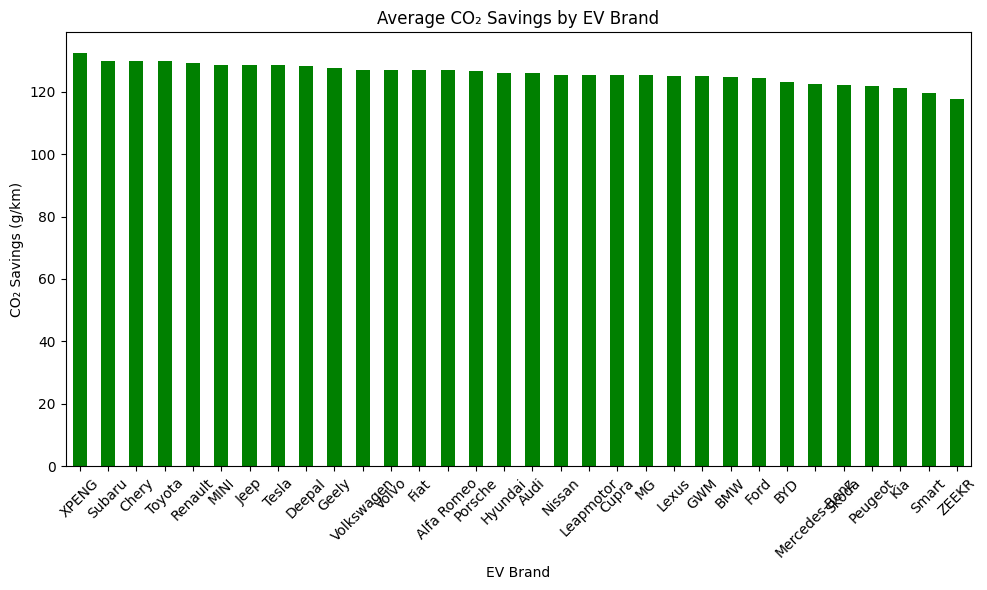

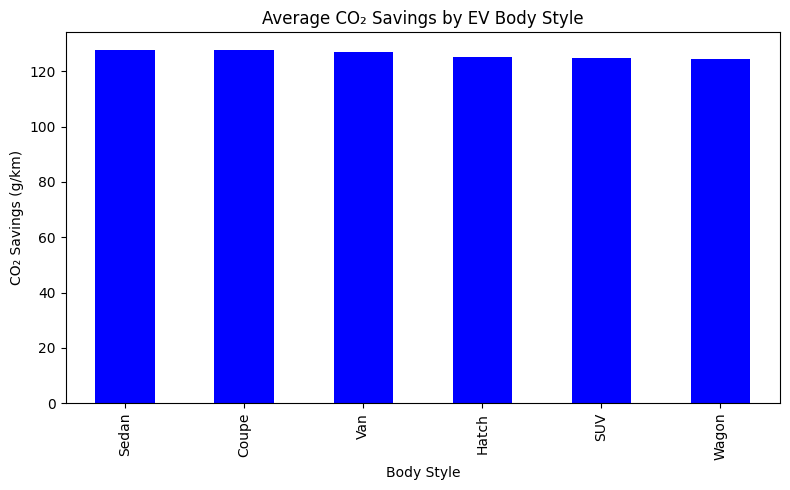

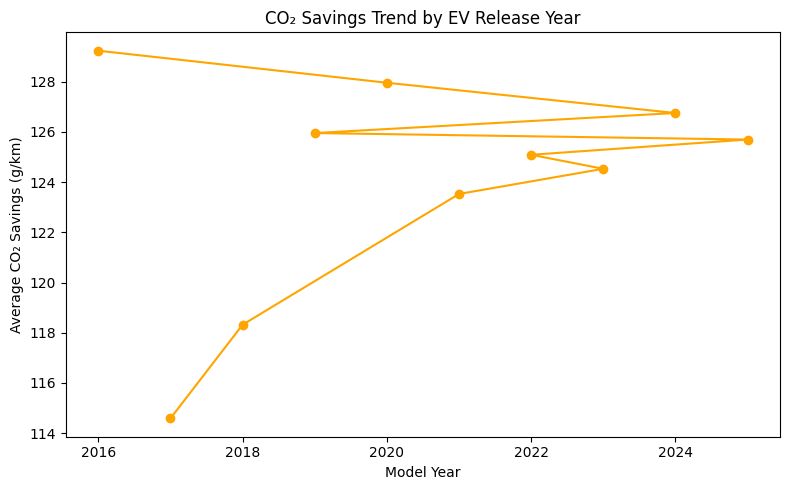

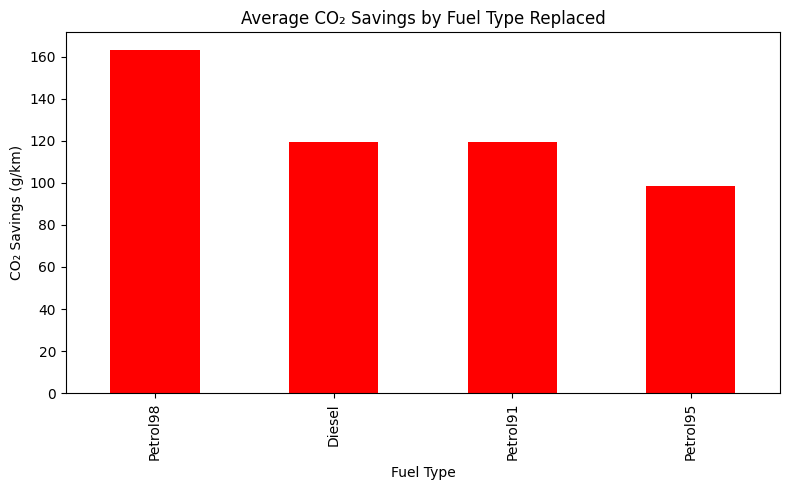

In [32]:

# EV brand savings
plt.figure(figsize=(10,6))
ev_brand_impact.plot(kind='bar', color='green')
plt.title("Average CO₂ Savings by EV Brand")
plt.ylabel("CO₂ Savings (g/km)")
plt.xlabel("EV Brand")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Body style savings
plt.figure(figsize=(8,5))
ev_body_impact.plot(kind='bar', color='blue')
plt.title("Average CO₂ Savings by EV Body Style")
plt.ylabel("CO₂ Savings (g/km)")
plt.xlabel("Body Style")
plt.tight_layout()
plt.show()

# Release year savings
plt.figure(figsize=(8,5))
ev_year_impact.plot(kind='line', marker='o', color='orange')
plt.title("CO₂ Savings Trend by EV Release Year")
plt.ylabel("Average CO₂ Savings (g/km)")
plt.xlabel("Model Year")
plt.tight_layout()
plt.show()

# Fuel type replacement
plt.figure(figsize=(8,5))
fuel_impact.plot(kind='bar', color='red')
plt.title("Average CO₂ Savings by Fuel Type Replaced")
plt.ylabel("CO₂ Savings (g/km)")
plt.xlabel("Fuel Type")
plt.tight_layout()
plt.show()
